### Task 7
1. Repeat plot 28.6 from MacKay book. Dataset: sklearn dataset. Prior: normal distribution with scalar covariance. Models: multiple linear regression models:
    1. with optimal hyperparameters
    2. with lowered variance for the prior
    3. with biased mean for the prior
* [book](http://www.inference.org.uk/itprnn/book.pdf)

#### Выгрузка датасета

In [1]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_diabetes
from sklearn import preprocessing
import matplotlib.pyplot as plt
import scipy.stats as stats
import math
import jax
from jax import jit
import jax.numpy as jnp

In [2]:
data, target = load_diabetes(return_X_y=True)
sigma_y = 0.1
data = preprocessing.StandardScaler().fit_transform(data)
target = preprocessing.StandardScaler().fit_transform(target[..., None]).flatten()

#### Используемый функционал

In [14]:
def get_optimal_model(X, y, sigma_y):
    '''
    Построение линейной модели с оптимальными гиперпараметрами
    '''

    alpha = np.random.normal(0, 0.001, size=(X.shape[1],))

    def get_loss(alpha, X, y):
        inner = sigma_y * jnp.eye(X.shape[0]) + jnp.matmul(jnp.matmul(X, jnp.diag(alpha)), X.T)
        loss = jnp.linalg.slogdet(inner)[1] + jnp.dot(jnp.matmul(jnp.linalg.inv(inner), y), y)

        return loss
    
    def step(alpha, X, y, lr=1e-7):
        loss, gradient = jax.value_and_grad(get_loss)(alpha, X, y)
        updated_alpha = alpha - lr * gradient
        
        return updated_alpha, loss
        
    for epoch in range(100):
        alpha, loss = step(alpha, X, y)
    
    return 1 / jax.lax.clamp(0., alpha, 1e5)

In [15]:
def get_evidence_disribution(X, mu, prior, sigma):
    '''
    Вычисление параметров для распределения обоснованности
    '''
    m = X.dot(mu)
    s = sigma * np.eye(X.shape[0]) + X.dot(np.diag(1/prior)).dot(X.T)
    return m, s

In [16]:
def get_posterior(X, y, mu, prior, sigma):
    '''
    Вычисление параметров для апостериорного распределения
    '''
    s = sigma * np.diag(1/prior) + data.T.dot(data)
    m = np.linalg.inv(s).dot(X.T.dot(y) + sigma * np.diag(1/prior).dot(mu))
    s = s / sigma
    return m, s

#### Построение графиков обоснованности (вертикальная ось графика из книги)

In [7]:
prior = get_optimal_model(data, target, sigma_y)

evidence_1 = get_evidence_disribution(data, np.zeros(10), prior, sigma_y)

prior1 = prior / 10
evidence_2 = get_evidence_disribution(data, np.ones(10), 
                                     prior1, sigma_y)

mu = np.random.normal(scale=1, size=prior.shape)
evidence_3 = get_evidence_disribution(data, mu, prior, sigma_y)

Text(0.5, 1.0, 'The evidence')

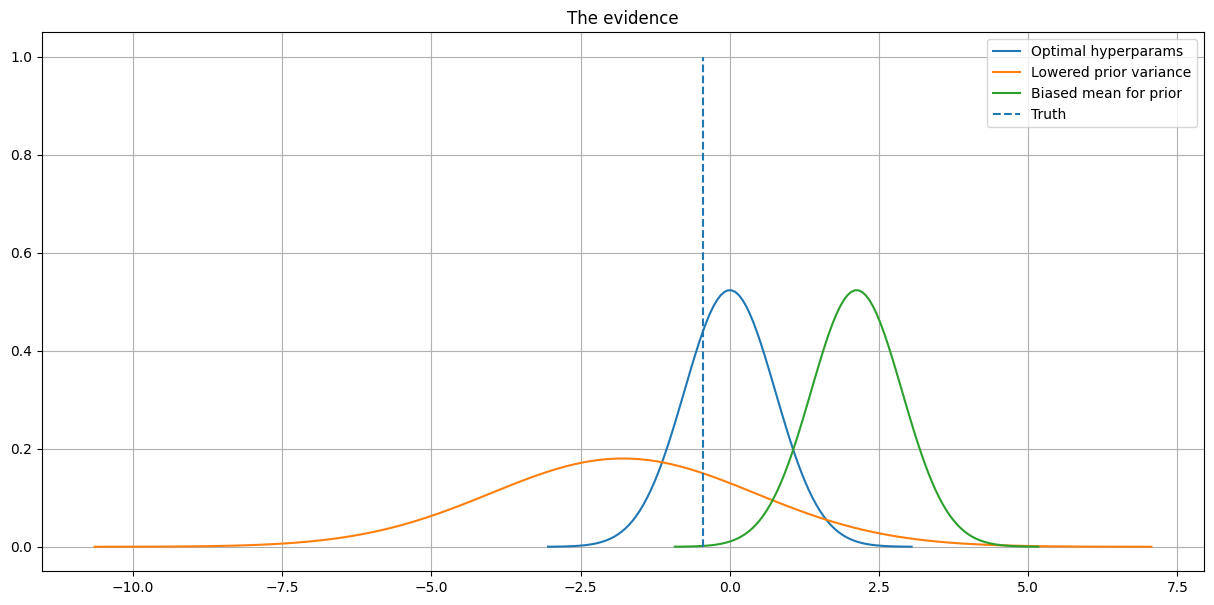

In [13]:
fig = plt.figure(figsize=(15, 7))

# Берём случайное наблюдение для построения распределения
rand_y = np.random.randint(0, data.shape[0], 1).item()

labels = ['Optimal hyperparams', 'Lowered prior variance', 'Biased mean for prior']
for label, ev in zip(labels, [evidence_1, evidence_2, evidence_3]):
    mmu = ev[0][rand_y]
    variance = ev[1][rand_y, rand_y]
    sigma = math.sqrt(variance)
    x = np.linspace(mmu - 4*sigma, mmu + 4*sigma, 100)
    plt.plot(x, stats.norm.pdf(x, mmu, sigma), label=label)
plt.vlines(target[rand_y], 0, 1, linestyles='--', label = 'Truth')
plt.grid(visible=True)
plt.legend()
plt.title('The evidence')

В книге обоснованность моделей сравнивается на примере их работы на одномерном датасете

На практике же имеется многомерная выборка. Поэтому, для построения распределений берётся случайное наблюдение из выборки

Из полученных зависимостей видно, что модель с оптимальными гиперпараметрами демонстрирует лучшие результаты

#### Построение апостериорного распределения (горизонтальная ось на графике из книги)

In [17]:
posterior_1 = get_posterior(data, target, np.zeros(10), prior, sigma_y)
posterior_2 = get_posterior(data, target, np.zeros(10), prior1, sigma_y)
posterior_3 = get_posterior(data, target, mu, prior, sigma_y)

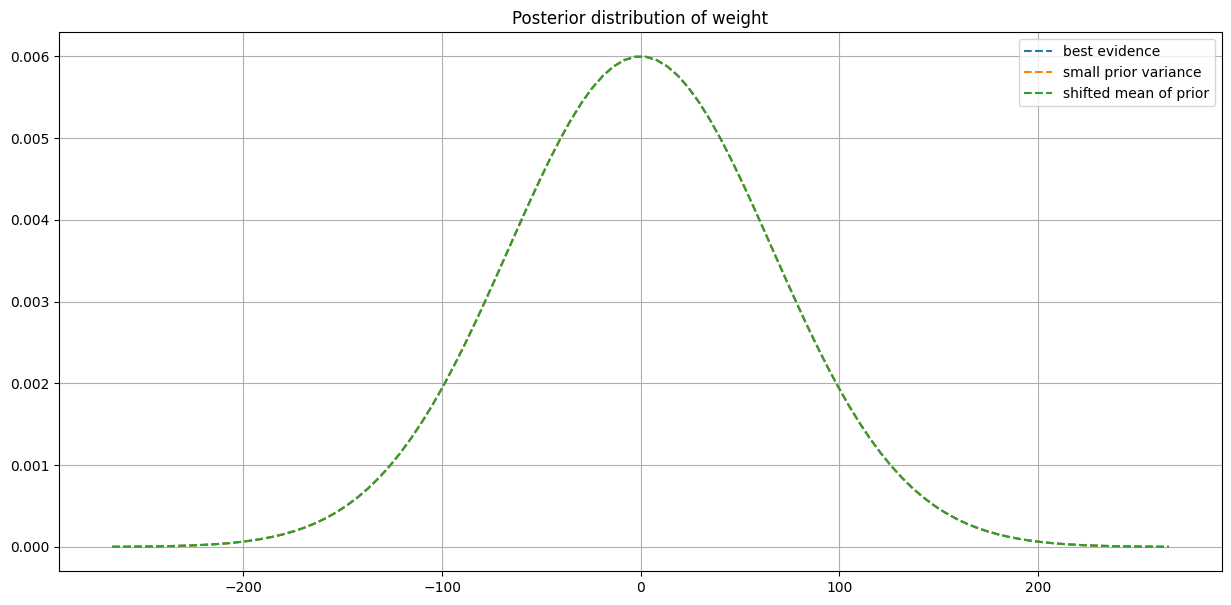

In [18]:
fig = plt.figure(figsize=(15, 7))
w = np.random.randint(0, data.shape[1], 1).item()
labels = ['best evidence', 'small prior variance', 'shifted mean of prior']
for label, post in zip(labels, [posterior_1, posterior_2, posterior_3]):
    mmu = post[0][w]
    variance = post[1][w, w]
    sigma = math.sqrt(variance)
    x = np.linspace(mmu - 4*sigma, mmu + 4*sigma, 100)
    plt.plot(x, stats.norm.pdf(x, mmu, sigma), '--', label=label)
plt.legend()
plt.title('Posterior distribution of weight')
plt.grid(visible=True)

Все три распределения практически не имеют различий